In [ ]:
#!pip install pysal

In [ ]:
#!pip install geopandas
#!pip install odfpy

In [1]:
import numpy as np
import pandas as pd
import geopandas
from pysal import lib as libpysal
import matplotlib.pyplot as plt

C:\Users\thiag\anaconda3\envs\TCC_IFES\lib\site-packages\pysal\explore\segregation\network\network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
C:\Users\thiag\anaconda3\envs\TCC_IFES\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
## DATASET Cachoeiro de Itapemirim
dataset_cachoeiro = geopandas.read_file("shapefile com ponte/Mapa_Cachoeiro.shp")
area_dos_bairros = pd.read_excel("atributos bairros/ÁREA_POPULAÇÃO_BAIRROS_SEPARADAMENTE_2018.ods_0.ods", header=0)

## Diminui para -2 os IDs dos bairros, ordena e indexa corretamente
dataset_cachoeiro['id'] = dataset_cachoeiro['id'].apply(lambda x : x-2)
dataset_cachoeiro = dataset_cachoeiro.sort_values(['id'])
dataset_cachoeiro = dataset_cachoeiro.reset_index(drop=True)
dataset_cachoeiro['nome'] = area_dos_bairros['NOME']
dataset_cachoeiro['população'] = area_dos_bairros['POPULAÇÂO_2019']

# Mudando ordem das colunas
dataset_cachoeiro = dataset_cachoeiro[['id','nome','geometry','Area','população']]

In [3]:
## Construindo função grafos linhas de adjacencia
contig_linhas_matrix = libpysal.weights.Queen.from_dataframe(df=dataset_cachoeiro)

In [4]:
import random
class Individuo():
  def __init__(self, lista_distritos_existentes: list, df: geopandas.GeoDataFrame, soma_populacao: int,geracao=0):
    self.geracao = geracao
    self.lista_distritos_existentes = lista_distritos_existentes
    self.nota_avaliacao = 0
    self.cromossomo = []
    self.df = df
    self.soma_populacao = soma_populacao
    
  def gerar_primeira_geracao(self, tamanho_cromossomo: int, dicionario_adjacencia: dict):
    self.cromossomo = ['' for x in range(tamanho_cromossomo)]

    bairros_selecionados = random.sample(range(0, 69), len(self.lista_distritos_existentes))
    for idx, distrito in enumerate(self.lista_distritos_existentes):
      self.cromossomo[bairros_selecionados[idx]] = distrito

    preenchimento_completo = False
    while preenchimento_completo != True:
      preenchimento_completo = True
      for idx, bairro  in enumerate(self.cromossomo):
        if bairro != '':
          #print("Bairro: ",bairro)
          bairros_adjacentes = dicionario_adjacencia[idx]
          #print("Bairros adjacentes: ", bairros_adjacentes)
          for bairro_adjacente in bairros_adjacentes:
            if self.cromossomo[bairro_adjacente] == '':
              self.cromossomo[bairro_adjacente] = bairro
        else:
          preenchimento_completo = False
  
  def soma_populacao_distrito(self, bairros_distrito: geopandas.GeoDataFrame):
    soma_populacao_distrito = bairros_distrito['população'].sum()
    soma_populacao_distrito = soma_populacao_distrito - round(self.soma_populacao/len(self.lista_distritos_existentes))
    return abs(soma_populacao_distrito)
  
  def soma_distancia_entre_centroids(self, bairros_distrito: geopandas.GeoDataFrame):
    centroides_dos_bairro = bairros_distrito.centroid
    centroide_principal = bairros_distrito.dissolve().centroid
    soma_distancia_entre_centroids = centroides_dos_bairro.distance(centroide_principal[0]).sum()
    return soma_distancia_entre_centroids
  
  def funcao_fitness(self):
    soma_total_populacao = 0
    soma_total_distancia = 0
    for i, distrito in enumerate(self.lista_distritos_existentes):
      bairros_pertencentes_distrito = [idx for idx, element in enumerate(self.cromossomo) if element == distrito]
      dataframe_bairros_pertencentes_distrito = self.df[self.df['id'].isin(bairros_pertencentes_distrito)] # ou dataset_cachoeiro.iloc[[53,16,20,49,47]]
      if self.verifica_contiguidade(dataframe_bairros_pertencentes_distrito) > 1:
        self.nota_avaliacao = 999999999
        return
      
      soma_total_populacao += self.soma_populacao_distrito(dataframe_bairros_pertencentes_distrito)
      soma_total_distancia += self.soma_distancia_entre_centroids(dataframe_bairros_pertencentes_distrito)
    self.nota_avaliacao = soma_total_populacao + soma_total_distancia
  
  def verifica_contiguidade(self, bairros_distrito: geopandas.GeoDataFrame):
    if len(bairros_distrito) < 1:
      return 2
    w = libpysal.weights.Queen.from_dataframe(bairros_distrito,silence_warnings=True)
    return w.n_components # Peguei da documentação https://pysal.org/libpysal/generated/libpysal.weights.W.html
  
  def crossover(self, outro_individuo):
    ponto_corte = round(random.random() * len(self.cromossomo))

    cromossomo_filho_1 = outro_individuo.cromossomo[0:ponto_corte] + self.cromossomo[ponto_corte::]
    cromossomo_filho_2 = self.cromossomo[0:ponto_corte] + outro_individuo.cromossomo[ponto_corte::]

    filhos = [Individuo(self.lista_distritos_existentes, self.df, self.soma_populacao ,self.geracao + 1),
              Individuo(self.lista_distritos_existentes, self.df, self.soma_populacao, self.geracao + 1)]
    
    filhos[0].cromossomo = cromossomo_filho_1
    filhos[1].cromossomo = cromossomo_filho_2

    return filhos
  
  def mutacao(self, taxa_mutacao):
    for i in range(len(self.cromossomo)):
      if random.random() < taxa_mutacao:
        distrito_escolhido = round(random.random() * (len(self.lista_distritos_existentes) - 1))
        self.cromossomo[i] = self.lista_distritos_existentes[distrito_escolhido]
    return self

In [5]:
import random
class AlgoritmoGenetico():
  def __init__(self, tamanho_populacao):
    self.tamanho_populacao = tamanho_populacao
    self.populacao = []
    self.geracao = 0
    self.melhor_solucao = 0
  
  def inicializa_populacao(self, lista_distritos_existentes, tamanho_cromossomo, dicionario_adjacencia, df, soma_populacao):
    for i in range(self.tamanho_populacao):
      individuo_N = Individuo(lista_distritos_existentes, df, soma_populacao)
      individuo_N.gerar_primeira_geracao(tamanho_cromossomo, dicionario_adjacencia)
      self.populacao.append(individuo_N)
      self.melhor_solucao = self.populacao[0]
  
  def orderna_populacao(self):
    self.populacao = sorted(self.populacao, key= lambda populacao: populacao.nota_avaliacao)

  def melhor_individuo(self, individuo):
    if individuo.nota_avaliacao < self.melhor_solucao.nota_avaliacao:
      print("Nota anterior: %s" % self.melhor_solucao.nota_avaliacao, " Nota Nova: %s" % individuo.nota_avaliacao)
      self.melhor_solucao = individuo
  
  def soma_avaliacoes(self, maior_avaliacao):
    soma = 0
    for individuo in self.populacao:
      soma += maior_avaliacao - individuo.nota_avaliacao
    return soma
  
  def seleciona_progenitor(self, soma_avaliacao, maior_avaliacao):
    progenitor = -1
    valor_sorteado = (soma_avaliacao * random.random())
    soma = 0
    i = 0
    while i < len(self.populacao) and soma < valor_sorteado:
      soma += maior_avaliacao - self.populacao[i].nota_avaliacao
      progenitor += 1
      i += 1
    return progenitor
  
  def resolver(self, lista_distritos_existentes, tamanho_cromossomo, dicionario_adjacencia, df, soma_populacao, taxa_mutacao):
    self.inicializa_populacao(lista_distritos_existentes, tamanho_cromossomo, dicionario_adjacencia, df, soma_populacao)

    for individuo in self.populacao:
      individuo.funcao_fitness()
    
    self.orderna_populacao()
    
    self.melhor_individuo(self.populacao[0])

    for geracao_atual in range(numero_geracoes):
      maior_avaliacao = self.populacao[-1].nota_avaliacao  
      soma_avaliacao = self.soma_avaliacoes(maior_avaliacao)
      nova_populacao = []

      for individuos_gerados in range(0, self.tamanho_populacao, 2):
       pai_1 = self.seleciona_progenitor(soma_avaliacao,maior_avaliacao)
       pai_2 = self.seleciona_progenitor(soma_avaliacao,maior_avaliacao)

       filhos = self.populacao[pai_1].crossover(self.populacao[pai_2])

       nova_populacao.append(filhos[0].mutacao(taxa_mutacao))
       nova_populacao.append(filhos[1].mutacao(taxa_mutacao))
      
        
      for individuo_novo in nova_populacao:
       individuo_novo.funcao_fitness()

      #nova_populacao = sorted(nova_populacao, key= lambda populacao: populacao.nota_avaliacao)
      self.populacao = list([*self.populacao[:self.tamanho_populacao//2],*nova_populacao[:self.tamanho_populacao//2]])  

      self.orderna_populacao()
      
      self.melhor_individuo(self.populacao[0])
      
    return self.melhor_solucao


# Main


Nota anterior: 246582.54723309295  Nota Nova: 190316.7914603257
Nota anterior: 190316.7914603257  Nota Nova: 189489.05092073476
Nota anterior: 189489.05092073476  Nota Nova: 182688.5704287911
Nota anterior: 182688.5704287911  Nota Nova: 176973.0173621268
Nota anterior: 176973.0173621268  Nota Nova: 175928.5031352613
Solucao Final: ['A', 'C', 'C', 'D', 'D', 'C', 'A', 'D', 'D', 'D', 'A', 'D', 'D', 'A', 'D', 'C', 'C', 'E', 'C', 'D', 'C', 'D', 'C', 'D', 'D', 'B', 'B', 'A', 'E', 'D', 'A', 'B', 'D', 'D', 'B', 'C', 'C', 'C', 'A', 'D', 'C', 'D', 'D', 'D', 'E', 'B', 'A', 'B', 'D', 'B', 'A', 'D', 'E', 'C', 'A', 'D', 'B', 'D', 'B', 'D', 'C', 'D', 'C', 'C', 'C', 'B', 'E', 'B', 'D']
 Nota:  175928.5031352613


<AxesSubplot:>

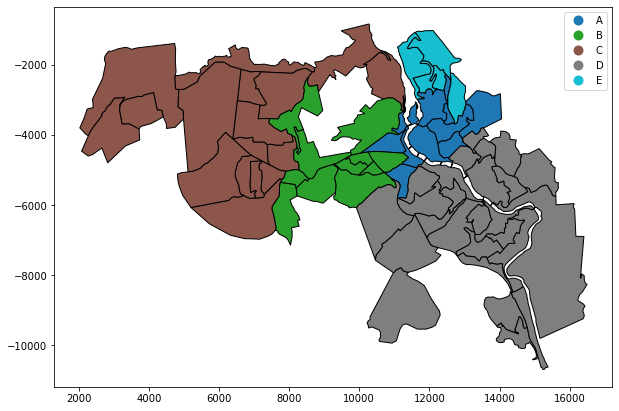

In [6]:
tamanho_populacao = 10
numero_geracoes = 100
lista_distritos_existentes = ['A','B','C','D','E']
soma_populacao = dataset_cachoeiro['população'].sum()

probabilidade_mutacao = 0.01

ag = AlgoritmoGenetico(tamanho_populacao)

result = ag.resolver(lista_distritos_existentes,69,contig_linhas_matrix.neighbors, dataset_cachoeiro, soma_populacao, probabilidade_mutacao)

print("Solucao Final: %s\n" % str(ag.melhor_solucao.cromossomo), "Nota: ", ag.melhor_solucao.nota_avaliacao)
dataset_cachoeiro['setor'] = result.cromossomo
fig, ax = plt.subplots(1, 1, figsize=(10,10))
dataset_cachoeiro.plot(column='setor', ax=ax, legend=True, edgecolor="black")


## Avalicação

### DIstribuição Utilizada Pela Policia Atualmente

137409.7110345652


<AxesSubplot:>

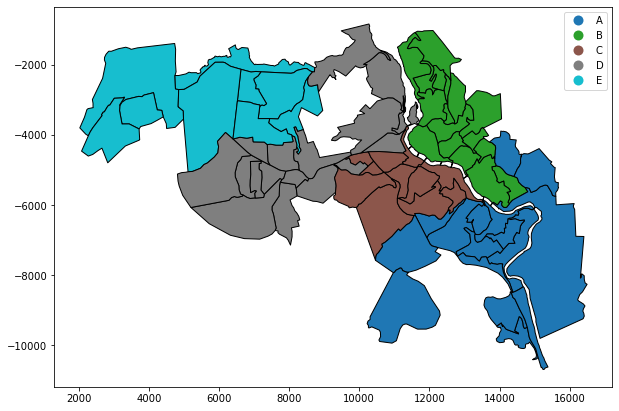

In [8]:
individuo_teste_divisao_cachoeiro = Individuo(df=dataset_cachoeiro,
                                              lista_distritos_existentes=['A','B','C','D','E'],
                                              soma_populacao=soma_populacao)
individuo_teste_divisao_cachoeiro.cromossomo = ['B','E','D','A','B','D','B','A','A','A','B','A','A','C','A','D','E','B','D','C','E','C','E','A','A','E','C','B','B','C','C','D','B','B','D','D','E','E','D','A','D','A','A','B','B','C','B','D','A','D','D','C','B','E','B','B','C','C','D','A','D','A','D','E','D','D','B','C','A']
                                              
individuo_teste_divisao_cachoeiro.funcao_fitness()
print(individuo_teste_divisao_cachoeiro.nota_avaliacao)

dataset_cachoeiro['setor'] = individuo_teste_divisao_cachoeiro.cromossomo
fig, ax = plt.subplots(1, 1, figsize=(10,10))

dataset_cachoeiro.plot(column='setor', ax=ax, legend=True, edgecolor="black") #edgecolor="black"